In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time
import os

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM10.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

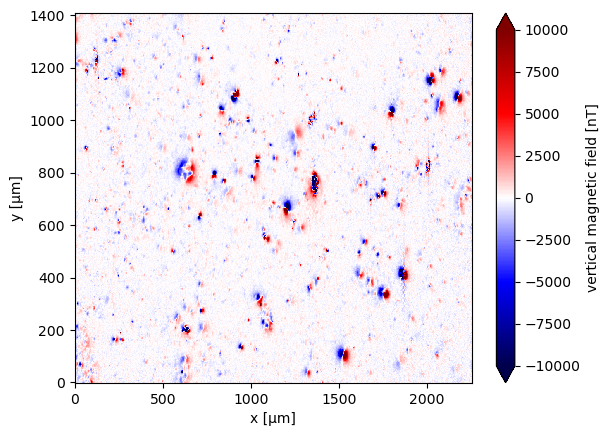

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB -10.63 -24.31 -53.25 ... -14.44 -9.424 -12.99

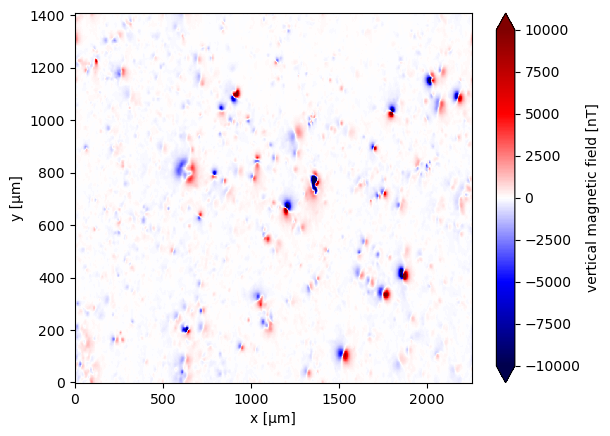

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB -10.63 -24.31 -53.25 ... -14.44 -9.424 -12.99
    tga      (y, x) float64 5MB 12.84 10.1 18.33 28.62 ... 4.119 2.776 9.682
    x_deriv  (y, x) float64 5MB -5.822 -9.068 -16.79 ... 1.99 0.3077 -1.519
    y_deriv  (y, x) float64 5MB 8.574 3.497 -1.476 -5.383 ... 2.386 2.753 0.7844
    z_deriv  (y, x) float64 5MB 7.585 2.744 7.2 7.994 ... 2.704 -0.1718 9.529

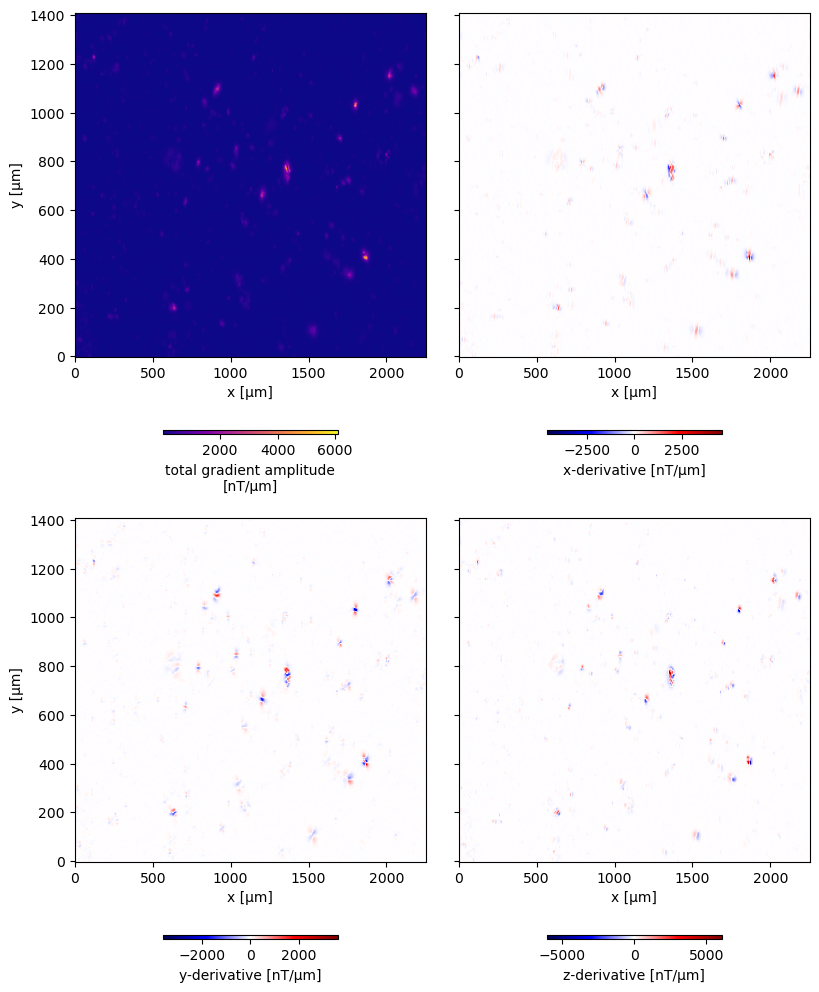

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

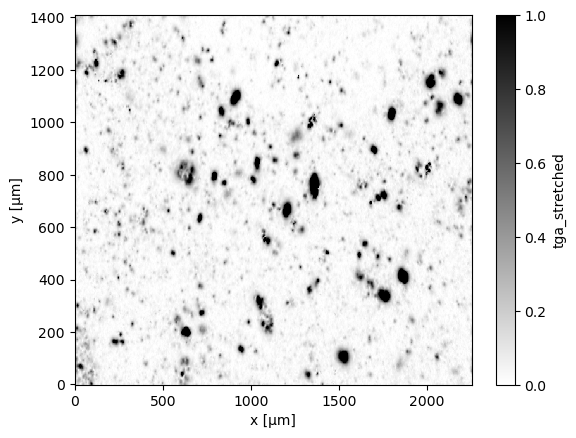

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

280 potential sources detected within 1.7874 seconds


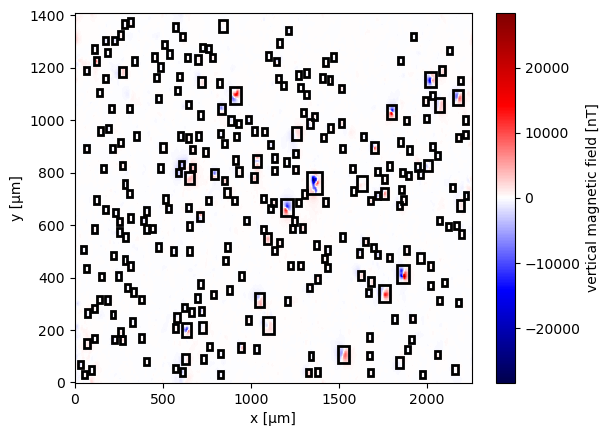

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

280 euler positions and dipole moments estimated within 2.0476 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 59.6135 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z          bz    z_deriv
0  1833.00  380.7  10.0 -230.972694 -35.915484
1  1835.35  380.7  10.0 -280.147335 -22.473399
2  1837.70  380.7  10.0 -330.704415 -14.612577
3  1840.05  380.7  10.0 -369.996237  -9.231243
4  1842.40  380.7  10.0 -392.044257  -7.250941

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

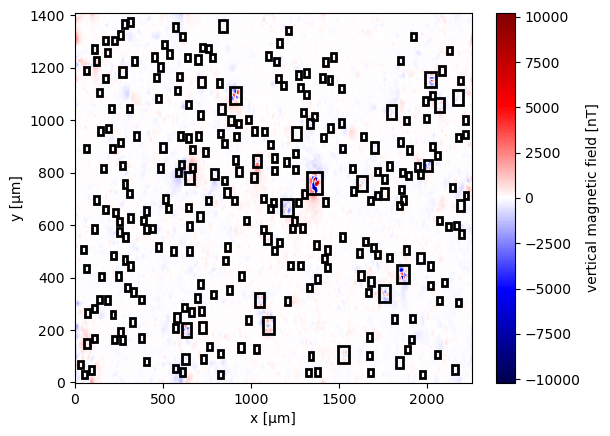

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

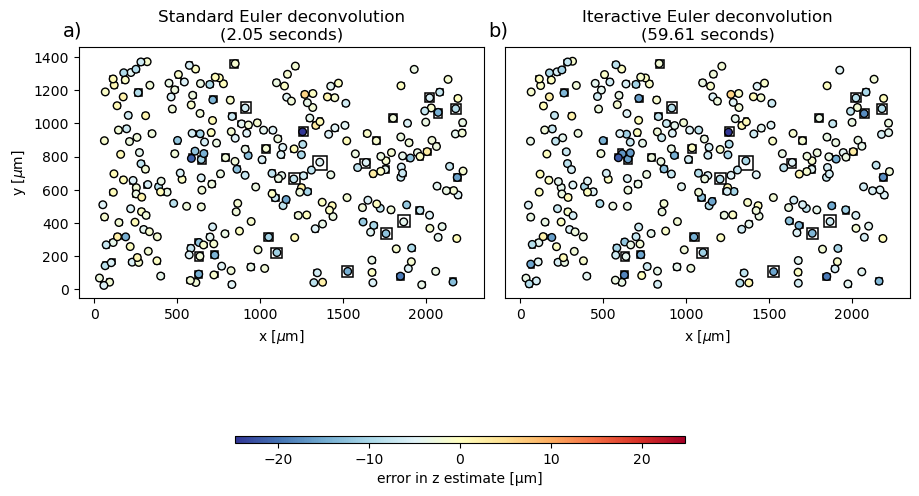

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

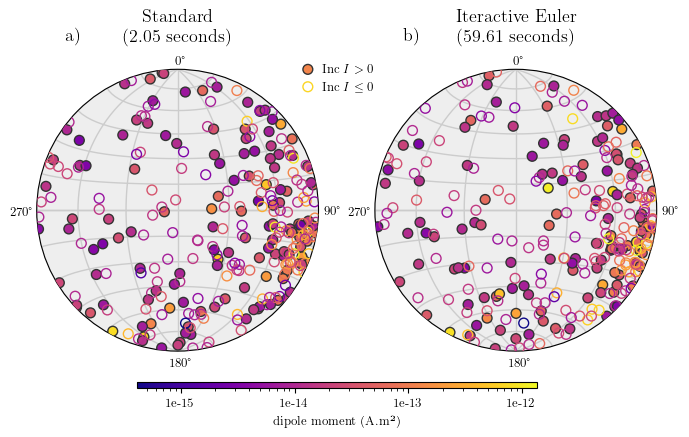

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

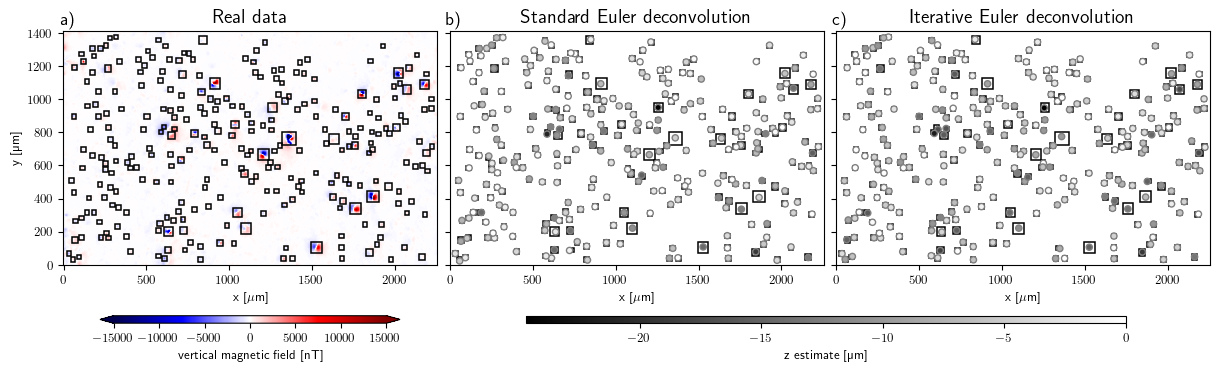

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


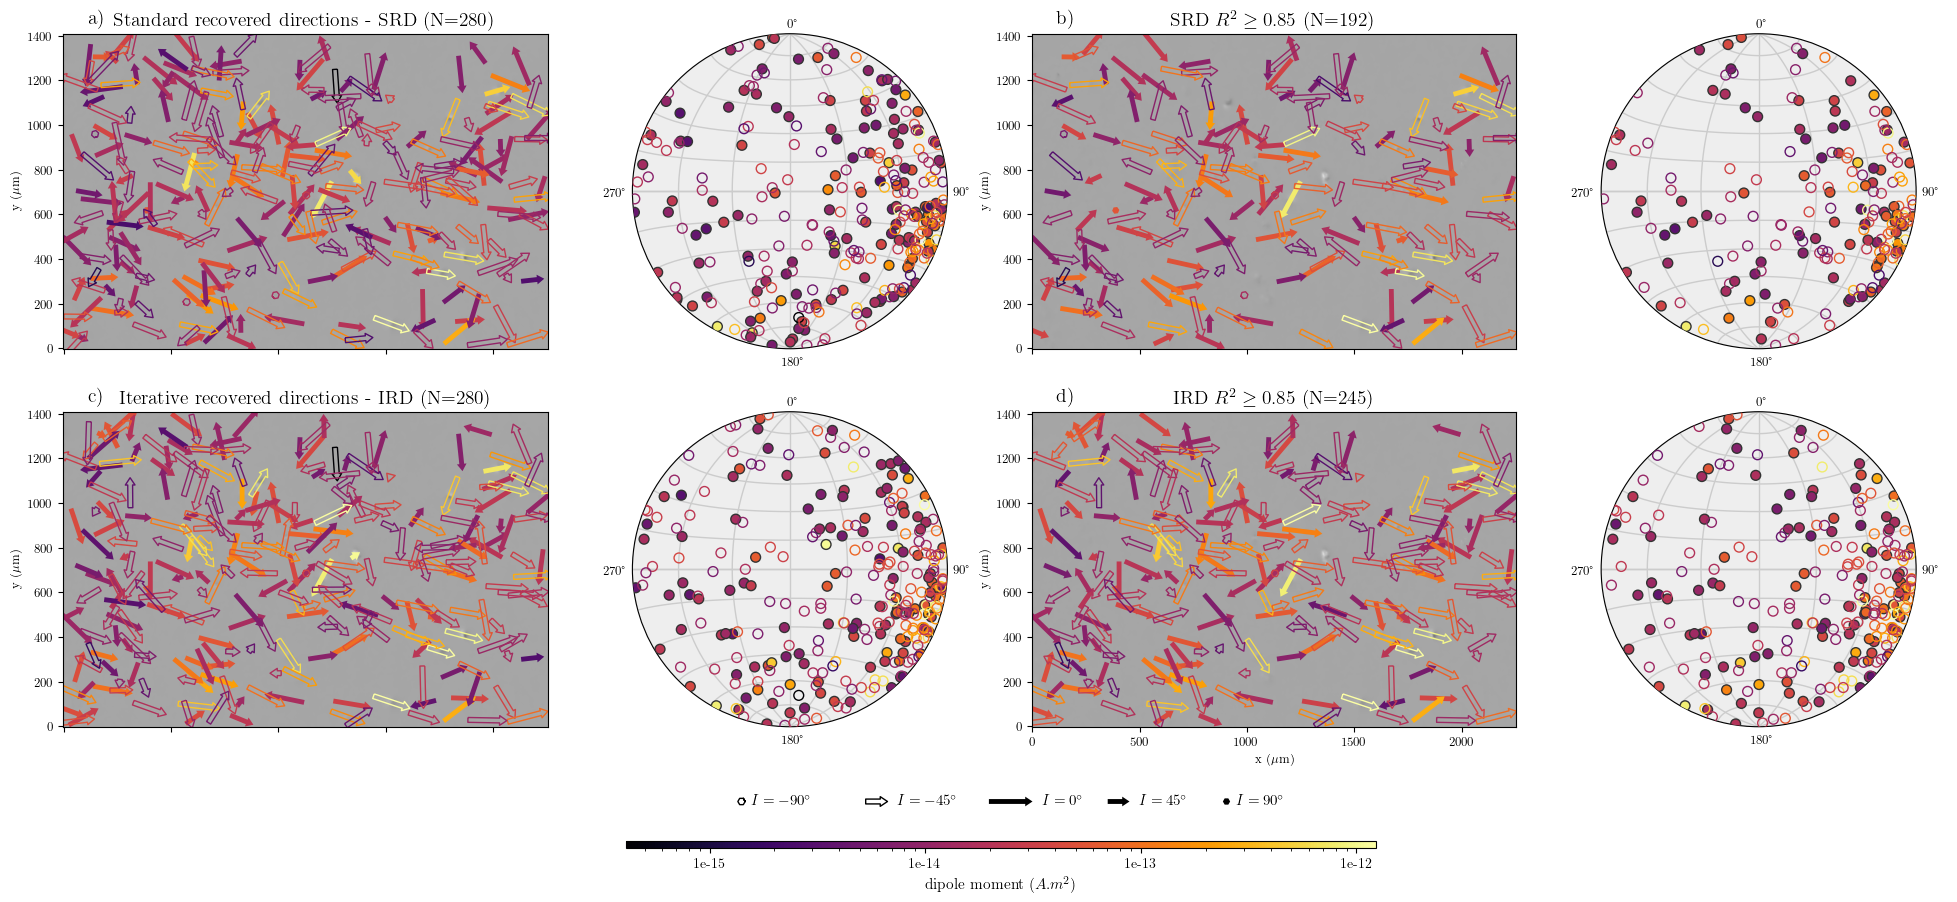

In [29]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

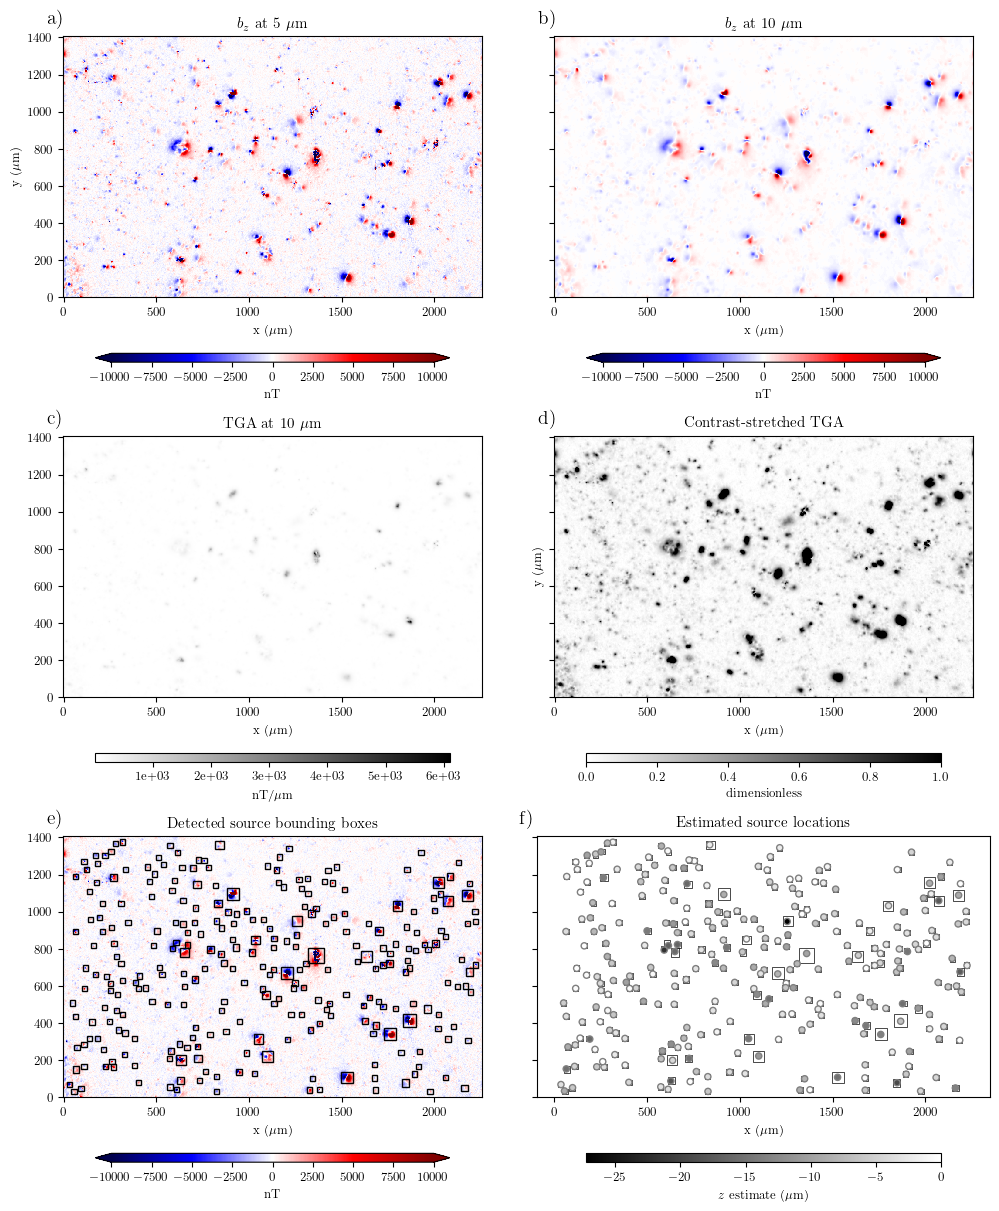

In [30]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [31]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [32]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB -4.484 -16.19 -43.33 ... -13.3 -7.372 -9.749
    tga      (y, x) float64 5MB 13.04 9.76 17.65 27.76 ... 5.741 4.6 3.033 10.15
    x_deriv  (y, x) float64 5MB -4.98 -8.265 -16.04 ... 2.336 0.7559 -1.011
    y_deriv  (y, x) float64 5MB 9.178 4.333 -0.4328 -4.138 ... 2.454 2.92 1.103
    z_deriv  (y, x) float64 5MB 7.81 2.856 7.335 8.165 ... 3.111 0.3138 10.04

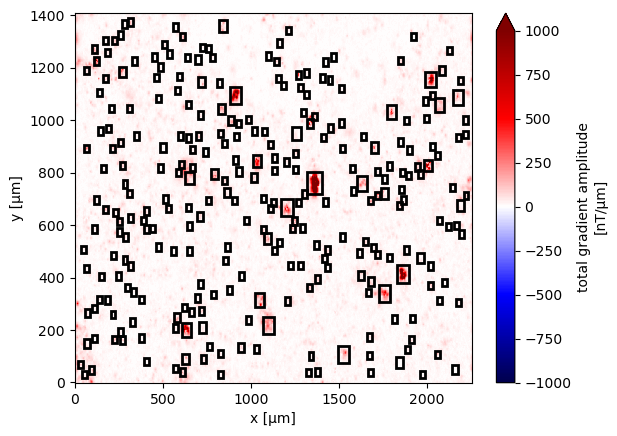

In [33]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [34]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [35]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.11,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [36]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

333 potential sources detected within 1.1591 seconds


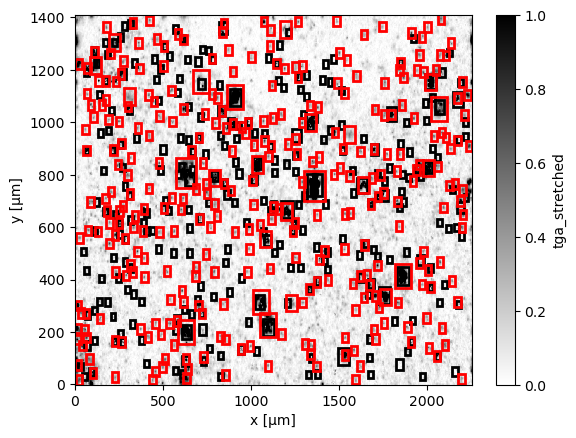

In [37]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [39]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ -1.93477631  34.83477631 282.41522369 319.18477631]
[2214.11522369 2250.88477631 1086.11522369 1122.88477631]
[1055.56522369 1092.33477631 1365.76522369 1402.53477631]
[   2.76522369   39.53477631 1203.61522369 1240.38477631]
[ -4.28477631  32.48477631 195.46522369 232.23477631]
[1687.71522369 1724.48477631  320.01522369  356.78477631]
[2221.16522369 2257.93477631  891.06522369  927.83477631]
[1701.81522369 1738.58477631  435.16522369  471.93477631]
[2181.21522369 2217.98477631  580.86522369  617.63477631]
[1816.96522369 1853.73477631  294.16522369  330.93477631]
[2061.36522369 2098.13477631 1375.16522369 1411.93477631]
[2021.41522369 2058.18477631  928.66522369  965.43477631]
[1939.16522369 1975.93477631 1238.86522369 1275.63477631]
[1102.56522369 1139.33477631 1121.36522369 1158.13477631]
[1849.86522369 1886.63477631 1151.91522369 1188.68477631]
[731.26522369 768.03477631 712.46522369 749.23477631]
[2084.86522369 2121.63477631  132.01522369  168.78477631]
[

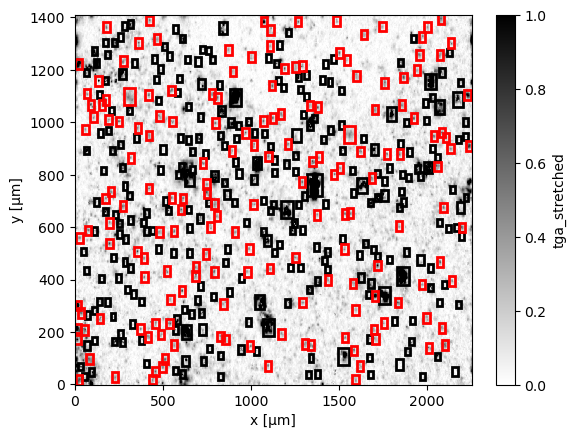

In [40]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [41]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 14.85197509 300.84999268  -3.1347042 ]

[-9.67683491e-15 -1.26324788e-15 -2.08426686e-14]

(64.91009657099994, -97.43753265493189, 2.30142078630969e-14)

0.9820729981168328

[2231.1699119  1104.45848286   -5.30668016]

[ 2.69093391e-14 -5.53163486e-15  7.83033100e-15]

(-15.909108987653545, 101.61622318263935, 2.8566161733868435e-14)

0.9884052329664617

[ 1.07240985e+03  1.38387645e+03 -1.14331569e+00]

[-3.73443254e-15 -2.87635282e-15 -6.04720017e-15]

(52.06386501440099, -127.6043587273261, 7.66733472346366e-15)

0.9118200254259621

[  20.37723701 1218.52568852   -8.22309104]

[ 5.28679103e-14  4.41385171e-14 -6.75634228e-15]

(5.602863065793808, 50.14207011601002, 6.920168195707993e-14)

0.860346649644361

[ 16.85787351 210.55673584  -9.68835818]

[ 4.67903957e-14 -2.14374923e-15 -5.18953625e-14]

(47.93136635110572, 92.6232295418127, 6.990754923041489e-14)

0.9122028090487349

[1716.42963328  338.04777148   -5.99783563]

[-3.19864445e-14 -1.08649068e-14  9.66921352e-15]

(-15.972680583875412, -108.7611975247253, 3.5137907190069636e-14)

0.7377767822724868

[2238.9739748   912.32595514   -5.28122304]

[ 1.32858505e-14 -1.04897139e-14  9.26940909e-15]

(-28.704555982442482, 128.29251319360878, 1.9299478408640532e-14)

0.9817696176110029

[1724.0274323   455.13020787   -3.3085329 ]

[ 6.24645543e-15  7.54527845e-15 -4.63618691e-15]

(25.328358442529037, 39.6200930365141, 1.0837142675418524e-14)

0.8842879150111717

[2199.72331234  600.28881202   -4.38913974]

[-4.12056821e-15  6.97597085e-15 -6.23672222e-15]

(37.58802129948709, -30.56950771119385, 1.0224478262383604e-14)

0.967648470378448

[1834.22656449  308.39300869   -4.80349871]

[7.06223297e-15 5.79910250e-15 6.22446898e-15]

(-34.26098113461774, 50.60911380243233, 1.1056615143055802e-14)

0.886767868731903

piorou

[2072.85494529 1401.20370356   -7.32125904]

[2.42350979e-14 1.80018995e-15 3.57953621e-15]

(-8.379114909034637, 85.75185491207452, 2.4564074054887494e-14)

0.6135761539594342

[2036.30804933  947.32871437   -4.57996968]

[-4.18891916e-15  5.12636850e-15 -5.36664925e-15]

(39.02998240969771, -39.25335390699748, 8.52218410321905e-15)

0.8608286489348213

[1955.99589448 1261.54096337   -7.89166648]

[ 6.45214464e-15  1.19246106e-14 -1.29167678e-14]

(43.61198252908241, 28.41684586934295, 1.872616878707701e-14)

0.8980222623998413

[1121.0215118  1143.80745457   -9.79507311]

[-8.68640671e-15  1.48546022e-14 -1.61975970e-14]

(43.26764594496633, -30.317472924448385, 2.363207602702961e-14)

0.9503231422270236

[1869.55132488 1172.1290846    -5.8517622 ]

[ 4.28423289e-15  3.50320958e-15 -1.08264883e-14]

(62.92523526271255, 50.72719470980328, 1.2158946394144659e-14)

0.9254806178023529

[756.2243287  728.59163526  -3.72122152]

[-8.26482201e-15  8.73463333e-15  7.96388269e-16]

(-3.789029058957986, -43.41692837096388, 1.2051362437078057e-14)

0.8498432604793493

[2100.40333716  149.78943603  -11.97395034]

[5.13214142e-14 1.08492006e-14 1.08561455e-14]

(-11.692781012825947, 78.06357288721726, 5.356723443645957e-14)

0.9605008755592493

[194.65446084 538.94017486  -4.46142898]

[ 5.32270034e-15 -6.28561420e-15  5.07190481e-15]

(-31.624067572749198, 139.7418495486284, 9.67286426803316e-15)

0.8896287037664321

[602.043542   666.40541156  -6.10060717]

[ 1.34625927e-14 -2.22610600e-15  4.53753945e-15]

(-18.393644339755568, 99.38918068814444, 1.4380063086575294e-14)

0.9326439742274084

[27.83408302 17.76848413 -9.42016732]

[ 3.90111112e-14 -3.89300370e-15 -1.13445434e-14]

(16.138626074115773, 95.69880339909385, 4.0813244646498745e-14)

0.8927550591255073

[ 1.62371511e+03  8.89300336e+02 -5.90175704e-01]

[ 3.34646899e-15 -2.12211252e-15 -7.56446209e-16]

(10.807525370301628, 122.38020705873767, 4.034157546400376e-15)

0.9422604754050362

[2058.07886923  839.44267972   -6.26706349]

[-4.65528079e-15  9.47936214e-15 -8.77036227e-15]

(39.7084740356308, -26.155489342088345, 1.3727680072900832e-14)

0.7673143150987185

[1761.03543618 1147.97837757   -5.2946897 ]

[2.65543206e-15 1.07643547e-14 4.10009466e-15]

(-20.29486652791559, 13.85747823159968, 1.182088948688813e-14)

0.9066532033986161

[538.50547823 234.00490415  -6.93214307]

[ 1.85920862e-14 -5.86273636e-15  2.53833288e-15]

(-7.4185935913681424, 107.50188954629587, 1.9659106795215718e-14)

0.9488552801442549

[2074.54524435  465.17848802   -5.20233856]

[3.95432778e-15 5.05850804e-15 6.67357296e-15]

(-46.106404015513654, 38.01538693876503, 9.260766047431489e-15)

0.9456365490376328

[1845.73604448  880.52074247   -3.04769974]

[ 2.97573440e-15 -6.27342474e-15  1.70461588e-15]

(-13.793403444830654, 154.62315769885262, 7.149585193763974e-15)

0.9558670300857405

[ 6.08850991e+02  3.59422922e+02 -4.82553985e-01]

[ 9.50596293e-16 -2.19879170e-15  1.92699663e-15]

(-38.81426721919822, 156.61988428070686, 3.074351036926495e-15)

0.9479876722365299

piorou

[ 101.12909409 1071.46035425    1.42058926]

[ 4.18500037e-16  1.05046352e-15 -1.15265433e-16]

(5.820417597850563, 21.722119296202198, 1.1366186756046577e-15)

0.18791407768066404

[417.28447316 182.11279319  -3.32303852]

[ 7.50459805e-15 -2.45536722e-15 -1.38225239e-15]

(9.929352277558738, 108.11714969497076, 8.016136335898367e-15)

0.9790820807225389

[513.85453561  94.05624442  -5.37518653]

[-4.96659976e-15  3.92183704e-15  8.23250513e-15]

(-52.4504493516328, -51.70388724788309, 1.0383740156154719e-14)

0.9306014607249679

[1705.32950852 1042.32914729   -7.04984897]

[ 1.00037290e-14 -1.23714265e-14 -7.05116803e-15]

(23.90254282137951, 141.04045431779545, 1.740246413037089e-14)

0.9243005252631464

[ 177.26189292 1365.10165567   -3.27524356]

[-3.45041306e-15  1.50407220e-15 -4.00237569e-15]

(46.75815811973269, -66.44709454228737, 5.494232851612447e-15)

0.9333069544646585

[1173.62056609 1029.99023595   -5.91602042]

[ 9.96912211e-15 -5.61247755e-15 -4.61994046e-15]

(21.99013632023995, 119.37890797431709, 1.2338036707684456e-14)

0.937147530119697

[ 418.88346392 1102.12678816   -3.92427291]

[ 7.86794425e-16 -5.27868430e-15 -4.40512406e-15]

(39.53604482576971, 171.5224056977366, 6.920164113662966e-15)

0.9648359111086474

[ 547.13642842 1121.14943995   -1.35372176]

[ 4.58928201e-15  1.94848313e-15 -5.34952384e-17]

(0.6147339026572681, 66.9952557892763, 4.986076375354012e-15)

0.9042208675945657

[ 782.56368282 1109.1633828    -5.67291763]

[ 1.16022800e-14  5.18276850e-15 -2.90418736e-15]

(12.87360878481294, 65.92956101410665, 1.3034887643431322e-14)

0.9557888346968023

[1351.77448156  849.87196472   -8.23711109]

[-1.25383293e-14  1.53964685e-14 -1.74191968e-15]

(5.013585755625511, -39.15813017536536, 1.9932265985378487e-14)

0.8053730900612501

[683.30138866 414.80472881  -0.69276817]

[ 1.91318384e-15  2.71582313e-15 -8.02924124e-16]

(13.587574112688266, 35.16309446602787, 3.417697300857227e-15)

0.6053219631344765

[ 18.95255148 168.98132488 -12.34037938]

[ 3.40881367e-14 -4.08279157e-14 -2.54687352e-14]

(25.5873051593493, 140.14074220193675, 5.897097793930811e-14)

0.9401511936616924

[ 805.07445146 1094.86695394   -7.45819826]

[ 1.07904553e-14 -5.46285642e-15  9.31788472e-15]

(-37.61151366724264, 116.85160972784038, 1.52676029931935e-14)

0.9144343607129748

[790.17645552 435.49983755  -5.04545447]

[ 6.02243032e-16  8.49436759e-15 -6.28796029e-15]

(36.442050070837766, 4.055433260482009, 1.058562336397012e-14)

0.8138077545737973

[2074.95251825 1256.57834881   -6.90821736]

[1.38965565e-14 9.99447117e-15 8.55967399e-16]

(-2.862738454518463, 54.27612766068911, 1.713874025797851e-14)

0.9436231295510968

[1267.51228892 1383.28252837   -2.79597943]

[-3.91768374e-15 -3.00493027e-15 -2.08476973e-15]

(22.891463616246952, -127.488821556779, 5.35948846678893e-15)

0.9452965523780349

[560.54664808 583.68742075  -4.05048722]

[-3.71904344e-15  1.20835377e-15 -4.68189911e-15]

(50.130645151238085, -72.00051137024163, 6.100129686699535e-15)

0.8092460070915002

[459.58286523  49.64278478  -2.37189556]

[ 4.75314899e-15 -1.11277272e-15 -2.74939175e-15]

(29.388532200489088, 103.17636573941044, 5.60266396080153e-15)

0.8983712078326511

[1924.40555295 1013.22065383   -3.80525136]

[7.32718705e-15 3.05546205e-16 3.39629984e-15]

(-24.84969432029359, 87.61212987050914, 8.081824119590116e-15)

0.8853542653260664

piorou

[ 1.25113022e+03  4.82862572e+02 -7.83625307e-01]

[-6.25776979e-16  1.69384699e-15  1.90720821e-15]

(-46.56532429573958, -20.276310365978112, 2.626434391492259e-15)

0.585528708704408

[1.50317548e+03 1.26205369e+03 6.19624416e-01]

[-1.86765327e-16 -1.84533606e-15 -9.64856286e-16]

(27.483657136746785, -174.22080852926968, 2.0907161723606127e-15)

0.8557522589585866

[355.82188458 509.93403275  -5.22863924]

[ 5.28216943e-15  9.53576304e-16 -5.99110047e-15]

(48.142171264954754, 79.76675961517313, 8.043873852324809e-15)

0.8140139427574282

[1557.34480037  957.0302388   -21.23893505]

[ 1.93165294e-13 -4.16430770e-14  3.86145719e-14]

(-11.057104533119494, 102.16578221961942, 2.0134066104106977e-13)

0.9790187330004786

[2016.36462211  140.83503151   -6.66911667]

[ 9.40139578e-15 -6.04061281e-15  3.44828371e-15]

(-17.149069475317777, 122.72167669848685, 1.1694695648966419e-14)

0.8174926078504156

[1293.60423149 1213.95073856   -1.93061925]

[4.20266435e-15 2.33865086e-16 1.75148868e-16]

(-2.382777089494255, 86.81495449165739, 4.212808763547154e-15)

0.8666679082228809

piorou

[1097.26384483  874.92828429   -1.8951778 ]

[ 4.06769313e-15 -3.21487344e-15  9.30846445e-16]

(-10.17820781868265, 128.32083971243472, 5.267638349621611e-15)

0.6772590448781366

piorou

[1068.12179737 1008.32538578   -1.35381731]

[ 2.60624906e-15 -2.62606120e-15  6.75448370e-16]

(-10.346098874713167, 135.21694934640453, 3.760978876334223e-15)

0.6196184582753963

[1292.41129401  311.26100448   -3.97945021]

[-7.55617673e-15  6.92518423e-17 -1.83498980e-15]

(13.649282379428584, -89.47490280555394, 7.776103788907889e-15)

0.9733730694064494

[612.40881655 709.43969327  -2.78241555]

[6.29850622e-16 4.82224933e-15 3.15896980e-15]

(-33.00633925766355, 7.441473385042929, 5.799128435879761e-15)

0.8343311850684412

[1123.00295805 1016.93548985   -3.22517717]

[ 3.50006531e-15 -7.31772835e-16  3.92136551e-15]

(-47.6394991192597, 101.80895756175964, 5.306887607333657e-15)

0.8497765239651166

[ 1.75868229e+02  1.08566752e+03 -3.21743417e-02]

[-2.03724503e-15  1.83766577e-15  2.02174762e-16]

(-4.214473463022378, -47.9484430142841, 2.7510466114506567e-15)

0.8798069660520129

[ 312.6698476  1095.40816575  -21.94138431]

[ 2.29176425e-13 -7.87621563e-14 -1.38261643e-14]

(3.265435484386503, 108.96655309894325, 2.427271595967932e-13)

0.9621479585913677

[ 426.1402402  1384.14891763   -6.64975918]

[ 6.26872526e-15 -8.83043627e-15 -6.34975693e-15]

(30.385238741233263, 144.62906389610077, 1.2553602435531493e-14)

0.8564478043433055

[1683.45337781  786.27353709   -9.43794071]

[ 1.74873585e-14 -3.19259254e-15  1.25199414e-14]

(-35.15708784896892, 100.34630228947162, 2.174279852594808e-14)

0.8306611675942556

[1595.96620306 1177.02153743  -12.12970969]

[ 3.49749810e-14 -5.70444613e-15  1.32705565e-14]

(-20.530006670485104, 99.26341875183793, 3.7840423783043566e-14)

0.9649456350339538

[ 2.10991619e+03  9.40024067e+02 -4.06872130e-01]

[-1.02380581e-15  1.25649250e-15  2.08336048e-15]

(-52.11823288020895, -39.17357864572967, 2.6395724330635314e-15)

0.8019241616887745

[ 281.70953486 1233.72658051   -8.78371824]

[ 1.80283491e-14  1.15247021e-14 -4.99270542e-15]

(13.134087355884214, 57.41107201027981, 2.197196483535819e-14)

0.8741567024251877

[ 38.49634565 273.53651173  -7.37134104]

[-1.28732367e-14 -1.07832787e-14  9.58694496e-15]

(-29.721827647485636, -129.95125619649775, 1.9336722521593666e-14)

0.9055929345116335

[ 22.08265934 557.43668357  -7.12841948]

[1.18794625e-14 2.48432460e-15 6.42522664e-15]

(-27.897438862238538, 78.18809769500501, 1.3732335355975182e-14)

0.9684502306191202

[424.38170744 944.34521236  -7.86230296]

[ 1.72803316e-14 -9.12206099e-15 -8.49004966e-15]

(23.48446686379165, 117.82898713921976, 2.130499468928505e-14)

0.8985547946550073

[ 876.32271731 1279.01011325   -9.08758743]

[ 1.06569949e-14  7.20769076e-15 -9.36112576e-15]

(36.040079771265425, 55.92816380381659, 1.591078319229431e-14)

0.9572370090573944

[358.51882467 980.54476163  -3.84191917]

[ 4.46812394e-15  4.71432457e-15 -2.64423367e-15]

(22.151200367013285, 43.464148380766424, 7.0129137585938585e-15)

0.8502354999879036

[421.78911916 751.5794408   -4.37322898]

[ 6.50933257e-15  3.16524775e-15 -1.39146644e-16]

(1.1013283883769847, 64.0680584866468, 7.239445116691789e-15)

0.7779985926254911

[ 2.09216630e+03  9.64981064e+02 -1.95828318e+00]

[-3.79270077e-15 -1.94511078e-15  2.11208239e-15]

(-26.35910899150193, -117.15130875044012, 4.7569871827961756e-15)

0.825703944417173

[1207.83292092  915.21681121   -6.29433825]

[ 8.53566278e-15 -2.18960841e-15  5.83438365e-15]

(-33.508256353250495, 104.38754754041979, 1.0568441544748117e-14)

0.8618266885189723

[273.50509802 675.38172045  -4.80466687]

[ 8.69554608e-15 -6.06501547e-15 -3.47137897e-15]

(18.130245986256515, 124.89520635218274, 1.1155599768865959e-14)

0.812793184870934

[728.0384203  843.30014946   4.20288197]

[ 4.40436892e-16 -2.03457669e-16 -2.07172558e-17]

(2.445156238437791, 114.79434529563089, 4.856015687215706e-16)

0.3236746914432589

[855.20221651 167.55382418  -7.02629672]

[4.62211461e-15 1.02716720e-14 6.70906766e-15]

(-30.779534649281914, 24.22710612602696, 1.311040725530242e-14)

0.9068446704067726

[1386.29573104 1055.09431465   -3.19097596]

[ 3.13794013e-15 -4.96544951e-15 -2.18728602e-15]

(20.42410204722716, 147.70896020845097, 6.267900544499862e-15)

0.7979154143248808

[148.36176477 249.13504328 -13.00515843]

[-9.6258120e-16 -2.1233194e-14 -2.5279534e-14]

(49.942917938259065, -177.40434222963785, 3.3027714573656855e-14)

0.9060728877694728

[1698.44493713  208.51943116   -6.21463611]

[ 3.84922364e-15 -1.06149073e-14  1.64519257e-15]

(-8.289935357155619, 160.0681234060217, 1.1410496855677422e-14)

0.9045091597644147

[520.78942263 432.63585062  -8.12877778]

[ 1.47014252e-14 -1.18330826e-14  4.99921608e-16]

(-1.517414493776712, 128.830364677253, 1.8878656449491757e-14)

0.9502870200211316

[1582.18220243  130.56351949   -2.72589982]

[ 3.75273550e-15 -1.56263347e-15  1.80625081e-15]

(-23.95719403564513, 112.60677231284085, 4.448301818733794e-15)

0.7569165938927276

piorou

[ 1.62124972e+03  6.94088010e+01 -6.11311027e-02]

[ 2.67018729e-15 -1.04235027e-15 -4.56578631e-17]

(0.9125587934399166, 111.32398194017898, 2.8667889462604534e-15)

0.6573328173544538

[1176.15994343  191.86156821   -2.52066828]

[ 3.54828452e-15 -3.64912304e-15 -5.48964594e-16]

(6.155844912846774, 135.80268403561126, 5.1193538778723435e-15)

0.9402997860346649

[394.32324777 481.12006869  -5.85829926]

[ 9.14860056e-15 -2.51007884e-15 -3.67098267e-15]

(21.15450223410813, 105.3425551615492, 1.0172192572282528e-14)

0.9799430975166283

[87.39771481 93.19684551 -5.98801967]

[-2.09391970e-14  8.86763387e-15  1.69770569e-16]

(-0.427755930984445, -67.04761160484186, 2.2740134631428856e-14)

0.8603217137171428

[ 55.62082619 203.37398756  -8.02323436]

[-2.81905171e-16 -2.17642937e-14  7.14255430e-15]

(-18.16725501684685, -179.2579096031206, 2.2908077893459427e-14)

0.772482841760285

[ 360.98146393 1299.55401655   -2.75098835]

[1.62534222e-15 3.88040967e-15 2.47640830e-15]

(-30.482436225449575, 22.726782682305714, 4.881794201024414e-15)

0.7567127570431627

[1563.00842408  650.80784911   -8.24276297]

[5.53221930e-15 2.15907734e-15 1.33608233e-14]

(-66.03584821937879, 68.68062726823764, 1.4621171786365867e-14)

0.9206342305153654

piorou

[ 488.23358421 1018.98660299   -8.47506804]

[-1.30507575e-14  5.38425923e-15  1.13300990e-14]

(-38.74841943255998, -67.5807694093956, 1.8102034703007715e-14)

0.5581757989081574

[1645.5031317  1336.06477763   -6.41776406]

[ 1.23693463e-14 -3.91633857e-15 -4.96562798e-16]

(2.1917613231427047, 107.56864403276558, 1.2984029013102286e-14)

0.9727601543568732

[1530.44944751  654.45736861    1.97808507]

[ 1.21462787e-15 -8.03791694e-16  7.32830391e-17]

(-2.880371766063665, 123.49498245656855, 1.4583457623279933e-15)

0.5383627101526943

[1307.27369993  153.65318106   -6.45335337]

[ 1.45491439e-14 -1.48443385e-15  3.21630250e-15]

(-12.403210335155698, 95.82566904744017, 1.4974168902056714e-14)

0.9442334070389412

[1332.0813376  1065.89546948   -9.7602933 ]

[ 1.28396567e-14 -1.02051743e-14  1.04975488e-14]

(-32.62103270536221, 128.47826556027587, 1.9473081342481468e-14)

0.9760567698162911

[2097.51493402  677.20647333   -9.90626193]

[-1.58544417e-14 -2.12152164e-15  9.89063006e-15]

(-31.729680223295166, -97.62161335656033, 1.880661426666498e-14)

0.8277288865692316

[768.34524752 602.47795956  -6.31134976]

[ 2.37781208e-15 -5.39125695e-15  6.70428701e-15]

(-48.68805218201451, 156.20013836914984, 8.925643177658331e-15)

0.8782200163168282

[1.01655815e+03 9.11579821e+02 2.73086658e-01]

[-1.34447692e-15 -1.90003138e-15  2.09779025e-16]

(-5.149960999731476, -144.71647941424843, 2.3370375835686137e-15)

0.7953107050483825

[1192.24037346 1205.62552582   -3.56138747]

[-3.42826993e-15 -3.17398546e-16  4.27013189e-15]

(-51.12138514175286, -95.28952021352957, 5.4852349909008745e-15)

0.7384713626942288

[ 1.34486602e+03  1.48083682e+02 -8.65508686e-01]

[ 3.98200126e-15 -1.29485619e-15 -1.10455675e-15]

(14.777485978361495, 108.01334624447335, 4.3304771289902145e-15)

0.7708461801279242

piorou

[1.77635176e+03 8.77317826e+02 1.69896742e+00]

[ 7.29990782e-17 -7.84582085e-16  5.12281733e-16]

(-33.02901678781428, 174.6843901756368, 9.39856631957557e-16)

0.40283021777034334

[1255.34934521 1210.27384752  -10.14561011]

[-9.16732256e-15  2.83721851e-14  4.65741209e-16]

(-0.8949031705985349, -17.906137646331334, 2.9820087263410573e-14)

0.9833168958897754

[ 898.83219509 1189.60091232  -13.67206388]

[ 8.27678699e-15 -3.45058906e-14 -1.90461103e-14]

(28.224321631793636, 166.511531092638, 4.027301836298186e-14)

0.9939569190982145

[1438.20911085  395.30673205   -5.20342819]

[ 1.77562371e-15 -7.98804326e-15 -3.63895712e-15]

(23.974551032963944, 167.4677543360865, 8.955650935473574e-15)

0.8732109723856326

[2087.77840177  215.4706154    -7.89897495]

[ 1.69074790e-14 -5.87995070e-15 -3.87178671e-15]

(12.20461319525904, 109.17625233950912, 1.8314677107714536e-14)

0.9737980406041469

[201.45117098 737.7269359   -6.58149666]

[ 7.48953314e-16 -9.56664360e-15  5.60252658e-15]

(-30.2783015814619, 175.52355897889026, 1.1111701264136289e-14)

0.8116883712823809

piorou

[787.5131924  691.36234985  -9.09512801]

[ 2.63194047e-14 -1.26205647e-14 -1.93318280e-17]

(0.03794707570141531, 115.61844383164514, 2.918886933297262e-14)

0.6806643168369717

[496.60488277  70.89355271  -3.98840993]

[-7.12217292e-15  1.83770727e-15 -2.99733032e-15]

(22.170815684130776, -75.53176374098169, 7.94270131405488e-15)

0.8479677768710323

[1853.61284462 1063.88392879  -12.43081808]

[2.41687606e-14 4.80568773e-16 2.79855633e-14]

(-49.180005547959006, 88.86088761581905, 3.698042308345454e-14)

0.8981721142526226

[230.74018347  22.08733701  -4.64420603]

[ 2.43863328e-15 -6.55682360e-15 -2.63747787e-15]

(20.65733632576121, 159.5986762009544, 7.4763064072932e-15)

0.6727680631958057

[ 65.1391464  584.05111791  -1.62508027]

[-1.22655490e-15  3.46329837e-15  5.65645676e-17]

(-0.8820314014785058, -19.50200841263744, 3.6745165778127374e-15)

0.5509407837439468

[1015.38334579  685.56036682   -1.84971673]

[ 4.06277292e-15  9.80598931e-16 -6.47544940e-16]

(8.80714679073686, 76.43050369801072, 4.229304020318234e-15)

0.8701922633748156

[744.30169698 498.60899206  -7.55438386]

[ 1.59448028e-14 -3.42467178e-15  1.88663944e-15]

(-6.598921511217021, 102.12199306714835, 1.6417201956111903e-14)

0.9565880828266379

[903.34474244 581.08894037 -14.08336079]

[ 4.67150654e-14 -5.16623786e-15  1.26269194e-14]

(-15.037918122096617, 96.31071946658743, 4.866648169088459e-14)

0.979663559387784

[441.72847345  18.98818479  -3.65434009]

[ 5.38432970e-15  4.99955510e-15 -1.33568212e-15]

(10.303058382402062, 47.122122847573316, 7.467971896061357e-15)

0.8549524047323562

[807.61531503 641.89526005  -6.77869458]

[ 9.55281043e-15 -3.06641120e-15 -5.31743685e-15]

(27.92359112740763, 107.796407544876, 1.1354919614667794e-14)

0.9428584128600213

[ 468.91351316 1313.66940459  -13.32182938]

[ 1.31113373e-14 -2.89023564e-14 -2.22713218e-14]

(35.05889922713111, 155.59893643740634, 3.8771963416250915e-14)

0.9597822337811387

[485.57337827 580.0693911  -11.40046129]

[ 3.24662063e-14 -1.07241019e-14 -6.51926497e-15]

(10.794957259021128, 108.27920712383519, 3.480749527017169e-14)

0.9796972513386091

piorou

[ 2.00899802e+03  1.36193127e+03 -1.63719176e+00]

[ 1.53198542e-15 -4.77972882e-16 -1.70109259e-15]

(46.668112692330205, 107.32769786693648, 2.3386221157794795e-15)

0.4992414725225274

piorou

[ 131.52716646 1176.92394601    3.34103886]

[-1.34642611e-15 -3.17684622e-16 -1.14590704e-16]

(4.735162761972148, -103.27593640439902, 1.3881346580497188e-15)

0.14480532062211549

[456.76380276 229.89370016  -4.83385438]

[-1.84419954e-15 -9.01385139e-15 -2.29263240e-17]

(0.14277138354797583, -168.4370797501081, 9.2006040224479e-15)

0.9378521048176921

[ 251.86735964 1007.62987694   -5.1952456 ]

[-5.71352803e-15  2.20095292e-15  2.30418083e-15]

(-20.622743069776035, -68.9324251613514, 6.542006232237374e-15)

0.6896675995510475

[ 9.91104110e+02  5.18672767e+02 -4.71387122e-02]

[ 3.46221552e-16  7.04859472e-16 -1.57117240e-15]

(63.443296134953904, 26.159915819484663, 1.7564962134523517e-15)

0.8015852966943113

[2140.50323367  898.15318153   -4.05924804]

[ 6.28145169e-15  1.81639752e-15 -3.30912867e-15]

(26.842861486782603, 73.87180012582498, 7.328456031151261e-15)

0.9396320497662777

[968.60653877 958.90418475  -6.47578715]

[7.24434019e-15 8.07932080e-15 3.61892206e-15]

(-18.44322891266842, 41.881058566610484, 1.1439077159115973e-14)

0.9242796852220954

[1595.54911798   19.48831845   -5.51535064]

[ 6.88807207e-15 -5.18940263e-15  2.93967252e-15]

(-18.822518449586475, 126.99399385841728, 9.111372619075337e-15)

0.9153439039243967

[800.99414041 995.39050798  -2.73575899]

[-4.21348707e-15  2.07069506e-15  2.05791245e-15]

(-23.669648527445798, -63.82844441294341, 5.126036965913644e-15)

0.9242568868731499

[1841.88569364  604.8533692    -5.20489827]

[ 3.63903478e-15 -8.30766564e-15  9.04189540e-17]

(-0.5711809069190962, 156.34497703546043, 9.070174093185766e-15)

0.9205307962261117

[1536.10417516  179.26458594   -6.39754388]

[9.42264101e-15 4.87321845e-15 2.07053212e-15]

(-11.044242521155011, 62.65281733445306, 1.0808400662643764e-14)

0.8921299552137516

[394.52242988 410.16291464  -2.80042845]

[-2.93810101e-15 -1.32153207e-15  2.44421072e-15]

(-37.18715988683156, -114.21779728638626, 4.043890533897266e-15)

0.8289584696552544

[994.38325336 143.82531101  -2.09239843]

[4.13689211e-15 2.59495965e-16 1.05059775e-15]

(-14.222676323432797, 86.41069463858997, 4.2760928598345916e-15)

0.8261526614807922

[ 1.28934051e+03  7.74214693e+02 -1.21111040e+00]

[ 2.09679165e-15 -1.16034792e-15  2.48836703e-15]

(-46.078075711143114, 118.9597950919962, 3.4546943470818857e-15)

0.8066780407968284

[1.75460703e+03 2.35075452e+02 5.59375009e-01]

[-1.00093438e-15  8.42745046e-16 -7.68891265e-16]

(30.439646976657933, -49.90401822227535, 1.5176569516405215e-15)

0.8893801818904842

[982.22168056 429.4956846   -1.79775955]

[ 3.42719139e-15 -1.59122091e-15 -7.33965429e-16]

(10.992474438961334, 114.90511128791435, 3.849198627080961e-15)

0.8889406184930468

[1708.92063313  174.6504527    -8.32361915]

[ 1.75831780e-14 -3.44836746e-15  1.92428717e-15]

(-6.12968979721595, 101.0958740479077, 1.8021161643899343e-14)

0.942971956197241

[ 105.03424429 1023.35138134   -4.65562334]

[ 5.36332894e-15 -5.14563222e-15  2.08207911e-15]

(-15.649141272024346, 133.81326812248068, 7.718670981020274e-15)

0.9010371609418564

[557.04668855 150.2518661   -7.73430984]

[ 1.64498171e-14 -1.85758087e-15  4.73782636e-15]

(-15.971013893150456, 96.44278130014905, 1.7219003715661727e-14)

0.9635004791627716

[313.29381395 862.30809454  -1.94982815]

[-1.02534695e-15 -2.49918555e-15 -1.67353118e-15]

(31.778949906522552, -157.6930088057911, 3.1777305390899562e-15)

0.844140403250038

[ 2.13900340e+03  1.30230195e+03 -1.09504938e+00]

[ 2.18282908e-15 -2.03676280e-15 -2.27072276e-16]

(4.349465462507751, 133.01742885381933, 2.9941121066813762e-15)

0.8155788490051701

[170.74324854 708.58483677  -1.86887888]

[3.02617891e-15 2.96748053e-16 1.18907700e-15]

(-21.358207627488397, 84.39946334253102, 3.2649230147066475e-15)

0.7196604284882286

[1593.73524174  283.78136624   -5.74335694]

[4.51279734e-15 5.80856197e-16 5.54717813e-15]

(-50.639974801844865, 82.6656075335834, 7.174532662132189e-15)

0.9117971435984625

[1967.94810831 1324.75538602   -4.94649888]

[-6.93537174e-15 -6.83539918e-15 -2.21803915e-15]

(12.831869180312436, -134.58405343477492, 9.987079693243207e-15)

0.8729418051433273

[ 191.03355422 1009.02376273   -3.30924484]

[6.32929319e-16 3.76043482e-15 2.56936110e-15]

(-33.97147764040774, 9.554065113918945, 4.5981611531929196e-15)

0.8464865583854664

[1108.12372267  441.85961911   -2.04640456]

[ 2.78636348e-15 -1.02319970e-15  1.90429188e-15]

(-32.681982082637205, 110.1640873028421, 3.526625390022926e-15)

0.7082390559854901

[829.32111252 180.46087817  -4.43262016]

[ 3.96309090e-15 -5.82438673e-15 -1.74142809e-15]

(13.88474800359119, 145.76743098846603, 7.256868610347756e-15)

0.8228002033207639

[1096.75153264   70.32774851   -1.39154302]

[1.98762611e-15 4.38532624e-16 1.87089743e-15]

(-42.588179513045986, 77.55808252814481, 2.7646384199884138e-15)

0.7242865045521679

piorou

[555.31178588 715.91007985  -2.42196205]

[ 1.12723164e-15 -1.38693080e-15 -2.32444120e-15]

(52.443664145795594, 140.89742374681714, 2.932107620370827e-15)

0.34374330120999086

[847.98502444 301.79954717  -9.5939526 ]

[ 9.14817085e-15 -1.33513636e-14 -8.62624183e-15]

(28.05689984509891, 145.58159367614024, 1.834011960521652e-14)

0.8733277456890879

piorou

[1976.69643012  376.01424945    2.0029996 ]

[-7.24656675e-16  6.67339822e-16  1.36269004e-16]

(-7.875560011673206, -47.357879264733526, 9.9450438762563e-16)

0.46616052004394304

[  66.31404484 1111.72072136   -4.17798247]

[ 4.16033362e-15 -4.02518574e-15  1.11638381e-15]

(-10.915572643322664, 134.05409795552575, 5.895490552788449e-15)

0.8488671687807601

[1377.39155213  643.94567176   -7.32426021]

[-8.59795374e-15  6.51710871e-15  3.34472157e-15]

(-17.224422168028603, -52.83846613018458, 1.1295338720082652e-14)

0.906126781193598

[ 58.88302429 977.4798092   -4.62553674]

[ 8.49633174e-16 -5.60420185e-15  2.80987083e-15]

(-26.368619539251757, 171.3792379966754, 6.3264784037407576e-15)

0.912013268353527

[490.21964285 193.68975572 -12.38680143]

[-2.55756126e-14 -1.48162911e-14 -5.89624339e-15]

(11.281564422098501, -120.08428098539922, 3.013967693937766e-14)

0.9343626867791319

[2149.07808265  391.16926895   -5.52736183]

[ 7.49679773e-15 -3.12907120e-15 -2.62918493e-15]

(17.934034144232424, 112.65505706930475, 8.538482077452155e-15)

0.8394828479560965

piorou

[1007.92233981 1246.68013055   -1.683802  ]

[-2.68253793e-15 -1.66760719e-15 -1.23958999e-16]

(2.2473957947818426, -121.86726586380567, 3.1610582570681e-15)

0.5416229165162536

[373.96228267 210.50100828  -3.44719294]

[ 3.39303282e-15 -1.36019848e-15 -1.70047828e-15]

(24.946963825211842, 111.84485458214553, 4.03167930481289e-15)

0.8450290179578831

[ 569.7235182  1006.47394393   -6.7915536 ]

[-1.16743952e-14  6.87277006e-16 -2.55576713e-15]

(12.327732851040885, -86.63085973861506, 1.197062230698678e-14)

0.45539652960635846

[1742.69231452 1368.92258532   -5.24011415]

[-4.62479120e-15  1.85371065e-15 -4.29093291e-15]

(40.73526768155349, -68.15808013864985, 6.57548796935402e-15)

0.8809719489298757

[750.02720683 758.87909975  -8.36864986]

[-1.21973913e-14  1.12441916e-14  6.87646229e-15]

(-22.51446631363662, -47.32852225486563, 1.795811608090498e-14)

0.9429451774541789

[1993.84936136  252.45469987  -11.03082279]

[ 3.04663131e-14 -3.24158930e-15  4.24569241e-15]

(-7.889504782030487, 96.07337162678087, 3.0931053005981415e-14)

0.952245437690374

piorou

[1108.58045731 1349.3398215    -2.15603377]

[ 7.71933212e-16 -4.43887988e-15 -1.08765188e-15]

(13.571843431077811, 170.13476809024277, 4.6349241715749766e-15)

0.6747416043606012

[1385.90489355  870.41066958  -10.07378629]

[ 8.10896683e-15  1.65582448e-14 -1.77542328e-15]

(5.500374430633966, 26.09209216120446, 1.8522498290894662e-14)

0.8753425841318985

[ 1.48786026e+03  1.38576450e+03 -1.28047228e+00]

[-1.92731430e-15  1.88969484e-15 -4.40092160e-16]

(9.26045006293521, -45.56467423259195, 2.7348067768513407e-15)

0.8290617630691726

[1.51915877e+02 1.06902557e+03 5.75352756e-02]

[-1.36480559e-15  1.80005377e-15 -3.20293644e-16]

(8.070076384771797, -37.16950179171238, 2.281551205704148e-15)

0.756932211625437

[1107.39068568 1290.54889767   -4.72363529]

[-3.95480623e-15  9.96595309e-16 -3.41606943e-15]

(39.94925944867817, -75.85617258694765, 5.320077529106936e-15)

0.94220883599281

[1469.88067916  802.61470115   -2.63976697]

[-3.63236602e-15  1.22679089e-15 -9.66306255e-16]

(14.146197378129283, -71.33817971217785, 3.953839468171232e-15)

0.8900240791456495

piorou

[ 1.51069459e+03  8.31445538e+02 -1.35915533e+00]

[-1.16763287e-15  2.07850515e-15 -2.22995918e-16]

(5.343771488461809, -29.32578290737422, 2.3944263127099384e-15)

0.3049605580861009

[1544.31669688 1240.67617266   -4.23761794]

[ 2.85327376e-15 -3.60654718e-15  1.37975858e-15]

(-16.70082619656983, 141.65116674850026, 4.801258946059087e-15)

0.8577833187314353

[680.25443701 451.89614551  -3.94456684]

[-4.17622004e-15  5.19638672e-15 -2.50668800e-15]

(20.606675129628133, -38.78806315216855, 7.122270244943645e-15)

0.638021386160467

piorou

[ 8.86366365e+02  8.92462860e+02 -1.73736589e-01]

[ 1.65957720e-15  4.14943805e-16 -1.96679694e-16]

(6.558649883365068, 75.96214792453657, 1.7219342998110459e-15)

0.40600781186525847

[192.43210325 620.22420243  -0.62350011]

[-1.33568122e-15  9.73422757e-16 -1.35411851e-15]

(39.328116476515234, -53.91604277298213, 2.136640616660871e-15)

0.6828672988011841

[547.55374322 322.98484383  -5.22532298]

[ 4.09541898e-15 -5.39865480e-15 -3.08268490e-15]

(24.461884316262193, 142.81604964202316, 7.444519893805069e-15)

0.878164807505837

piorou

[1944.30864622 1191.48475577   -6.67683166]

[ 2.53164124e-15 -8.95162322e-15 -1.05194172e-15]

(6.451534761316182, 164.2083727821834, 9.362016187548262e-15)

0.46082577122357926

[1582.00579512  386.75879992  -11.73252402]

[ 2.81438596e-14 -8.91002305e-15  8.16716313e-15]

(-15.464630701957287, 107.56718961324131, 3.062952659410477e-14)

0.9051923759302072

[ 1.53303009e+03  5.18925335e+02 -1.13319014e+00]

[ 1.81727667e-17  2.78212910e-15 -3.86995894e-16]

(7.918897510666022, 0.3742486379059278, 2.8089746161878856e-15)

0.7961422901039197

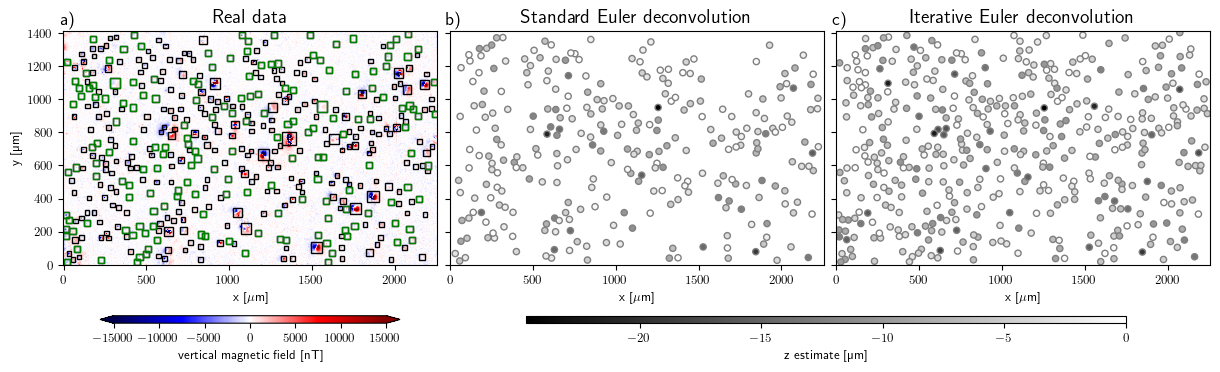

In [46]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


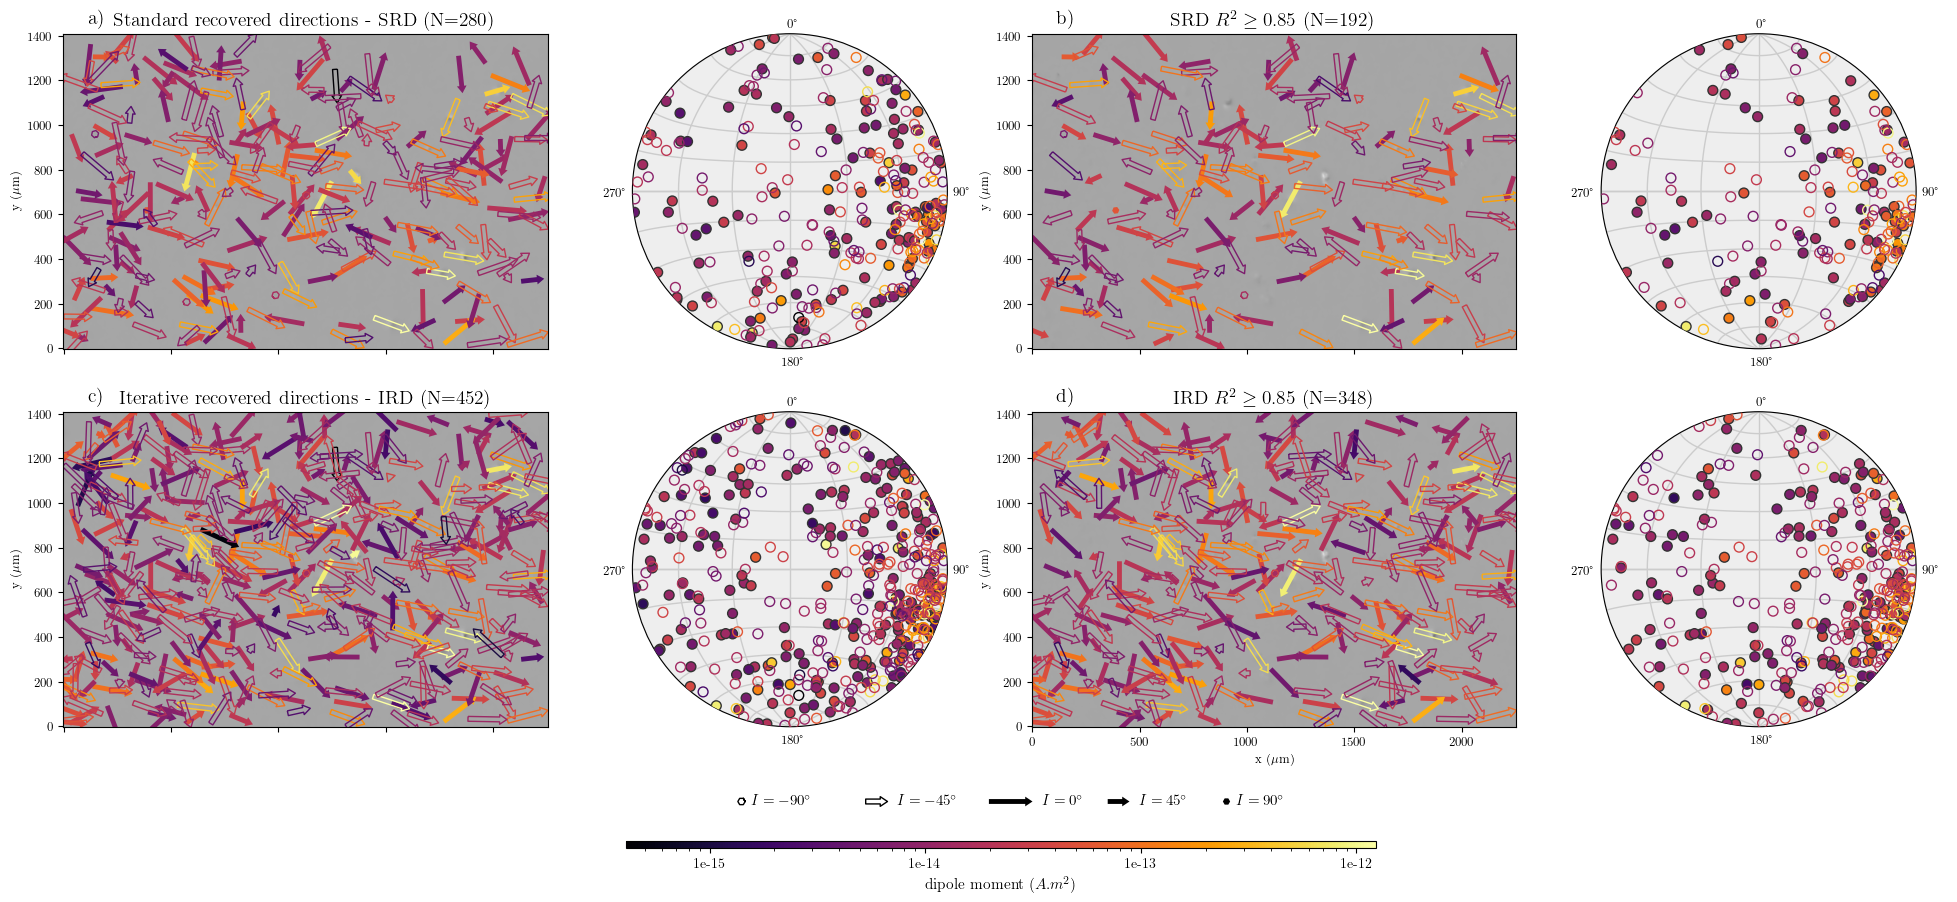

In [47]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    

    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

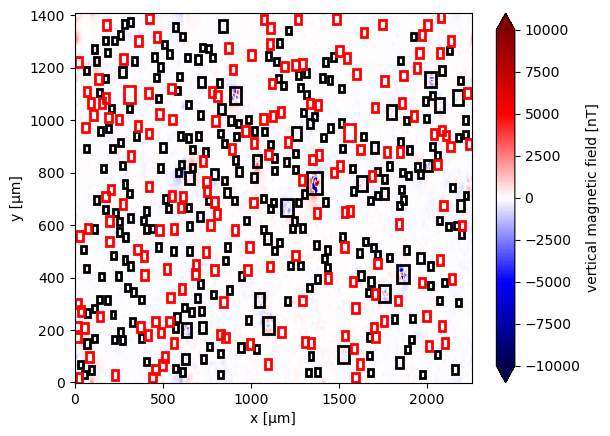

In [48]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

# Show the observed and predicted data

In [49]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

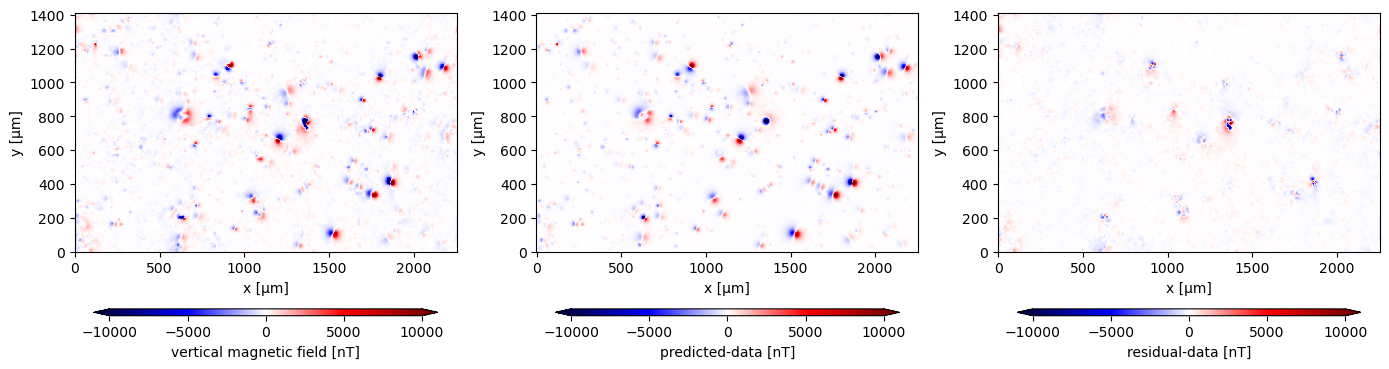

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9217401940810366


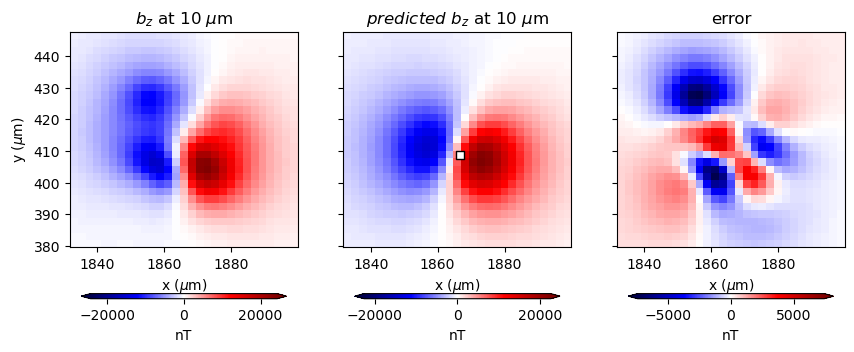

2
Individual source:   R2 = 0.8798073199665687


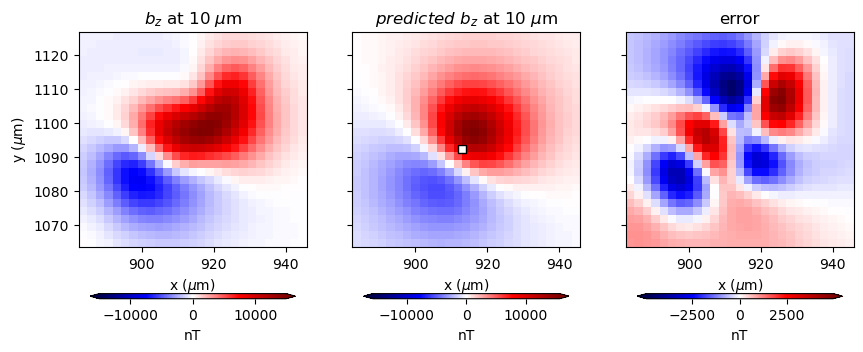

3
Individual source:   R2 = 0.9964299657291692


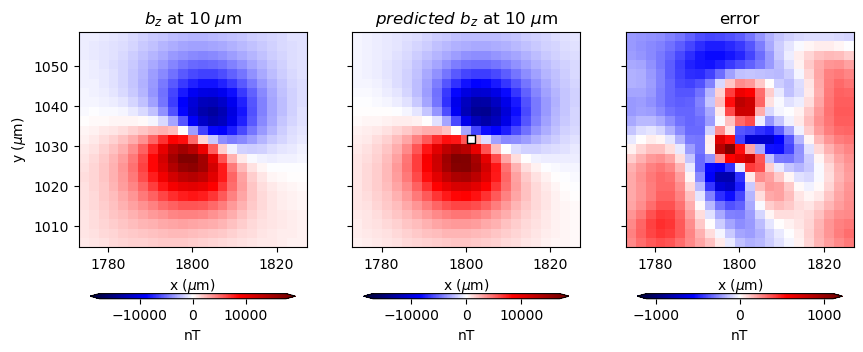

4
Individual source:   R2 = 0.9947518221700793


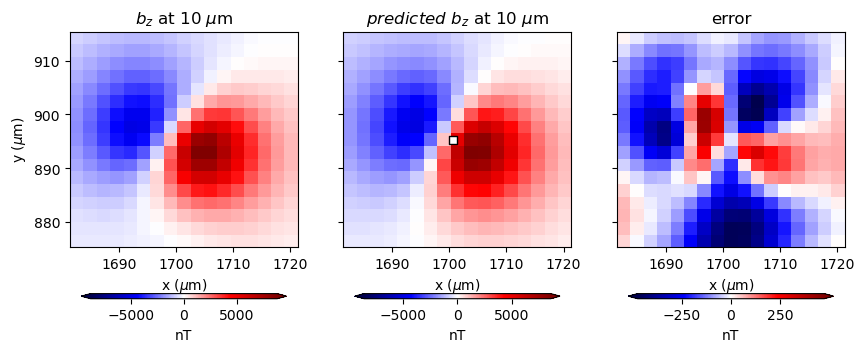

5
Individual source:   R2 = 0.9810466152840717


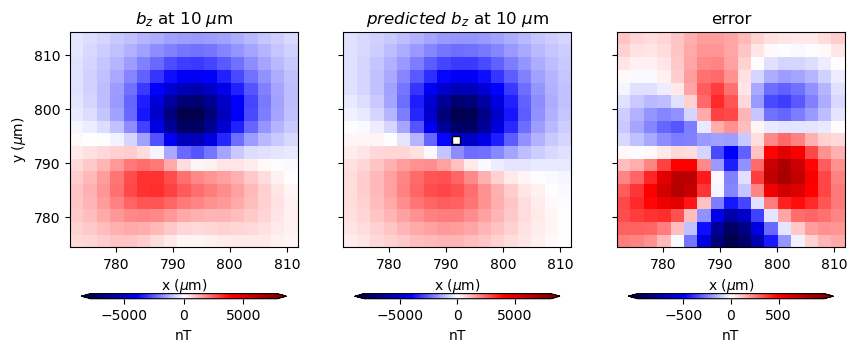

In [51]:
i = 0
slice_start=0#-20
slice_end=5#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [52]:
# Nome do arquivo ZIP
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [53]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)